In [1]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import datetime
import seaborn as sns


In [2]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [76]:
#imports the raw data in chunks. SQL export could not accomodate one CSV dump

USMTO1 = pd.DataFrame.from_csv('USMTO1.csv', index_col = False)
USMTO2 = pd.DataFrame.from_csv('USMTO2.csv', index_col = False)
USMTO3 = pd.DataFrame.from_csv('USMTO3.csv', index_col = False)
USMTO4 = pd.DataFrame.from_csv('USMTO4.csv', index_col = False)
USMTO5 = pd.DataFrame.from_csv('USMTO5.csv', index_col = False)

In [121]:
SP_500 = pd.DataFrame.from_csv('SP_500.csv', index_col = False)

In [128]:
USMTO_WHOLE.columns

Index(['OrderID', 'AAID', 'NAICSID', 'CustomerZipCode', 'ShippingCountryID',
       'ShippingZipCode', 'Units', 'TotalSale', 'CreatedBy', 'CreateDate',
       'ChangedBy', 'IsSubmitted', 'TopCategoryName', 'SubCategory',
       'SubCategoryName', 'Description', 'MachineCode', 'EntryMonth',
       'EntryYear', 'OrderDateFormatted', 'ChangedDateFormatted',
       'SubmitDateFormatted', 'OrderDateEOM', 'DaysLate', 'IsEmailOne',
       'IsEmailTwo', 'IsCall', 'IsBackfill'],
      dtype='object')

In [132]:
USMTO_WHOLE = USMTO_WHOLE.merge(SP_500, how='inner', on = ['EntryMonth', 'EntryYear'])

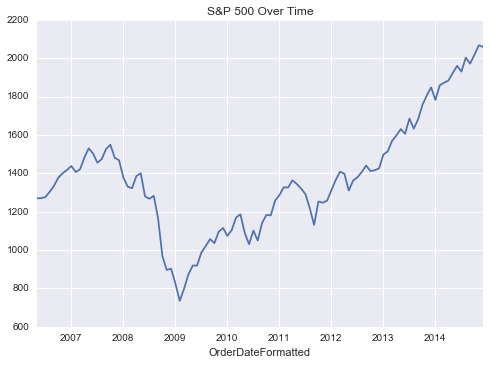

In [201]:
USMTO_WHOLE.groupby(['OrderDateFormatted'])['Close'].mean().plot(kind = 'line', title = 'S&P 500 Over Time')

In [77]:
#re-combines raw data

USMTO_WHOLE = USMTO1.append(USMTO2).append(USMTO3).append(USMTO4).append(USMTO5)

In [78]:
#format order date to datetime to prepare for analysis

USMTO_WHOLE['OrderDateFormatted'] = pd.to_datetime(USMTO_WHOLE.OrderDate)

In [79]:
#format changed date to datetime to prepare for analysis

USMTO_WHOLE['ChangedDateFormatted'] = pd.to_datetime(USMTO_WHOLE.ChangedDate)

In [80]:
#format submit date to datetime to prepare for analysis

USMTO_WHOLE['SubmitDateFormatted'] = pd.to_datetime(USMTO_WHOLE.SubmitDate.fillna(''))

In [81]:
#more formatting to get Order Date at End of Month

USMTO_WHOLE['hyphen'] = "-"

USMTO_WHOLE['OrderDateEOM'] = (USMTO_WHOLE.EntryYear.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.EntryMonth.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.OrderDateFormatted.dt.days_in_month.astype(str))

In [82]:
#format OrderDateEOM to datetime

USMTO_WHOLE['OrderDateEOM'] = pd.to_datetime(USMTO_WHOLE['OrderDateEOM'])


In [83]:
#create column DaysLate which indicates how many days late the order was submitted

USMTO_WHOLE['DaysLate'] = (USMTO_WHOLE['SubmitDateFormatted'] - USMTO_WHOLE['OrderDateEOM']).dt.days - 10

In [84]:
#fill all NaN with "0" -> count=141

USMTO_WHOLE['DaysLate'] = USMTO_WHOLE['DaysLate'].fillna('0')

In [85]:
#cast DaysLate and TotalSale as float64

USMTO_WHOLE['DaysLate'] = pd.to_numeric(USMTO_WHOLE['DaysLate'])
USMTO_WHOLE['TotalSale'] = (USMTO_WHOLE['TotalSale'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [86]:
#drop un-needed columns

USMTO_WHOLE = USMTO_WHOLE.drop('SubmitDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('OrderDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('ChangedDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsCancel', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('CancelOrderID', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('hyphen', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsMatch', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsIgnore', axis=1)

In [87]:
#creates columns IsEmailOne, IsEmailTwo, IsCall indicating when reminders are made for a member to submit

USMTO_WHOLE['IsEmailOne'] = USMTO_WHOLE['DaysLate'] >= 1
USMTO_WHOLE.IsEmailOne = USMTO_WHOLE.IsEmailOne.astype('int')       

USMTO_WHOLE['IsEmailTwo'] = USMTO_WHOLE['DaysLate'] >= 5
USMTO_WHOLE.IsEmailTwo = USMTO_WHOLE.IsEmailTwo.astype('int')    

USMTO_WHOLE['IsCall'] = USMTO_WHOLE['DaysLate'] >= 10
USMTO_WHOLE.IsCall = USMTO_WHOLE.IsCall.astype('int')

USMTO_WHOLE['IsBackfill'] = USMTO_WHOLE['DaysLate'] >= 90
USMTO_WHOLE.IsBackfill = USMTO_WHOLE.IsBackfill.astype('int')

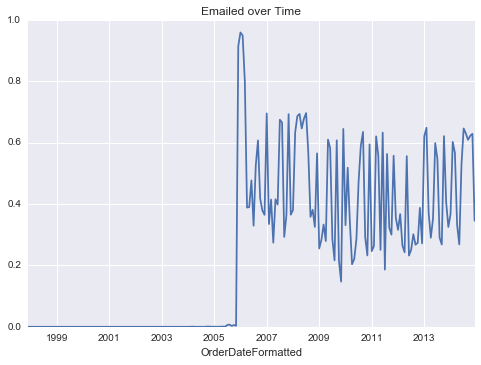

In [91]:
#shows the need to truncate data set

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsEmailOne'].mean().plot(kind = 'line', title = 'Emailed over Time')

In [92]:
#tosses the former half of data which may not be relevant

USMTO_WHOLE = USMTO_WHOLE[(USMTO_WHOLE.OrderDateFormatted >= '2006-05-01')]



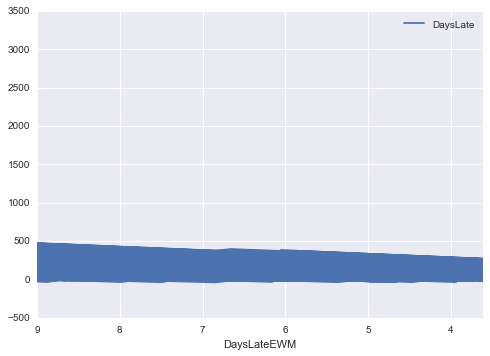

In [200]:
#create moving average for days late

USMTO_WHOLE['DaysLateEWM'] = USMTO_WHOLE.DaysLate.ewm(span=90).mean()

USMTO_WHOLE.plot(x='DaysLateEWM',y='DaysLate')

In [185]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 100 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 90]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe


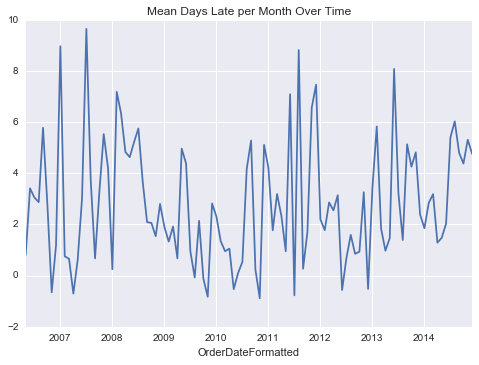

In [119]:
#Plots days late in a time series. Exhibit 1A, to be shared with team.

USMTO_NO_SUBMIT_BACKFILL.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line', title = 'Mean Days Late per Month Over Time')

In [95]:
#possible causes of change in oscillation
#box and whisker plots - how distribution changed over time
#change of median, edge, etc?
#potential companies that may have joined around 2005


In [96]:
#restricts Backfill table to suspicious DaysLate years

USMTO_NO_SUBMIT_BACKFILL_2005_2006 = USMTO_NO_SUBMIT_BACKFILL[USMTO_NO_SUBMIT_BACKFILL.EntryYear.between(2005,2006,inclusive = 'True')]

In [97]:
#Investigation of LateDays Spike in 2005. Exhibit 1B, to be shared with team.

USMTO_NO_SUBMIT_BACKFILL_2005_2006.groupby(['EntryYear','EntryMonth'])['DaysLate'].mean()

EntryYear  EntryMonth
2006       5              0.811528
           6              3.440760
           7              3.284892
           8              2.874966
           9             10.388842
           10             2.791005
           11            -0.653747
           12             1.196773
Name: DaysLate, dtype: float64

In [98]:
#Further investigation into Dec 2005 to March 2006

USMTO_NO_SUBMIT_BACKFILL_2005_2006_RESTRICT = USMTO_NO_SUBMIT_BACKFILL[USMTO_NO_SUBMIT_BACKFILL.OrderDateFormatted.between('2005-12-01','2006-03-01',inclusive = 'True')]
Export = USMTO_NO_SUBMIT_BACKFILL_2005_2006_RESTRICT.groupby(['EntryYear','EntryMonth','AAID'])['DaysLate'].mean()
Export.to_csv('Suspicious Records 2005-2006')

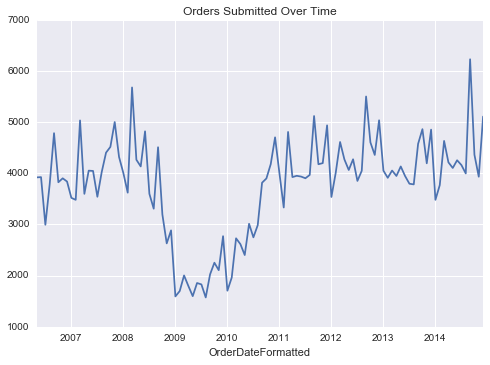

In [99]:
#plot order submission trend. Exhibit 2

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsSubmitted'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

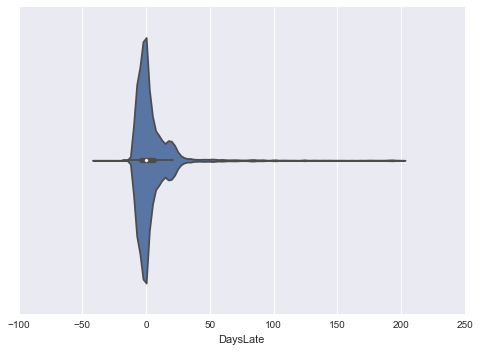

In [100]:
#plots distribution of days late

sns.violinplot(USMTO_NO_SUBMIT_OUTLIERS.DaysLate, title = 'Distribution of Days Late, 1997 to present')


In [236]:
#Creates table by AAID and OrderDateFormatted

AAID_BY_MONTH = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['DaysLate','TotalSale','IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill'].mean()
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2 = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['Units','TotalSale'].sum()
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH = AAID_BY_MONTH.merge(AAID_BY_MONTH_2, how = 'inner', on = ['AAID','OrderDateFormatted'])
AAID_BY_MONTH['TotalSaleAvg'] = AAID_BY_MONTH['TotalSale_x']
AAID_BY_MONTH['TotalSale'] = AAID_BY_MONTH['TotalSale_y']
#AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_x')
#AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_y')
AAID_BY_MONTH

,AAID,OrderDateFormatted,DaysLate,TotalSale_x,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Units,TotalSale_y,TotalSaleAvg,TotalSale
0,123,2007-12-01,522.0,1.846154e+04,1,1,1,1,13,240000.00,1.846154e+04,240000.00
1,123,2010-10-01,673.0,1.000000e+05,1,1,1,1,2,200000.00,1.000000e+05,200000.00
2,100005,2006-05-01,-5.0,1.314387e+05,0,0,0,0,7,920071.00,1.314387e+05,920071.00
3,100005,2006-06-01,1.0,1.539455e+05,1,0,0,0,2,307891.00,1.539455e+05,307891.00
4,100005,2006-07-01,-8.0,5.797109e+04,0,0,0,0,11,637682.00,5.797109e+04,637682.00
5,100005,2006-08-01,15.0,6.599400e+04,1,1,1,0,1,65994.00,6.599400e+04,65994.00
6,100005,2006-10-01,3.0,1.063480e+05,1,0,0,0,1,106348.00,1.063480e+05,106348.00
7,100005,2006-11-01,-3.0,1.291431e+05,0,0,0,0,15,1937146.00,1.291431e+05,1937146.00
8,100005,2006-12-01,-7.0,6.636000e+04,0,0,0,0,1,66360.00,6.636000e+04,66360.00
9,100005,2007-01-01,-9.0,1.997450e+04,0,0,0,0,4,79898.01,1.997450e+04,79898.01


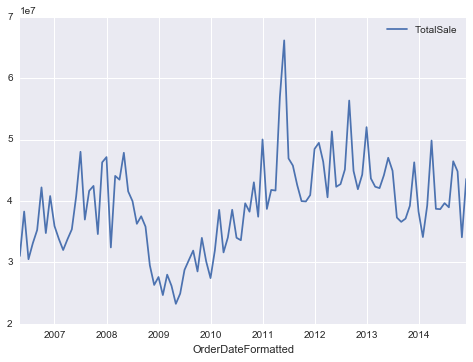

In [102]:
#average sales over time

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).sum()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='TotalSale')

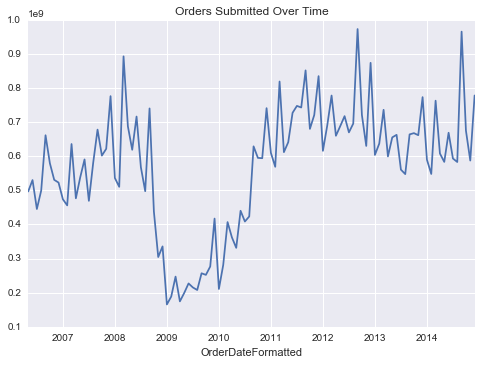

In [103]:
#plot of orders submitted over time

USMTO_WHOLE.groupby(['OrderDateFormatted'])['TotalSale'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

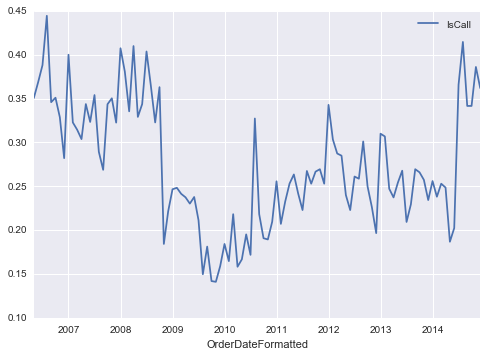

In [104]:
#percentage of company by month who needed to be called

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsCall')

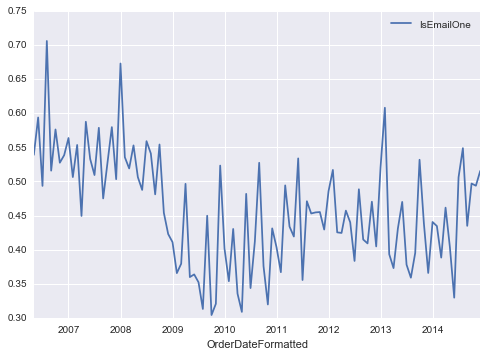

In [105]:
#percentage of company by month who needed to have first email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailOne')

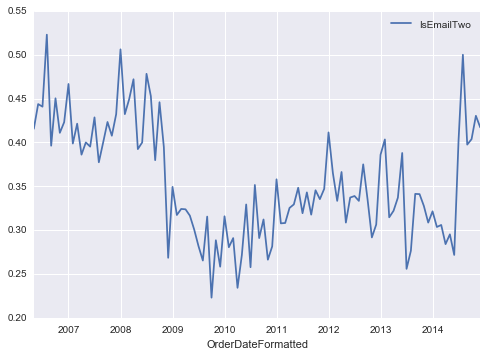

In [106]:
#percentage of company by month who needed to have second email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailTwo')

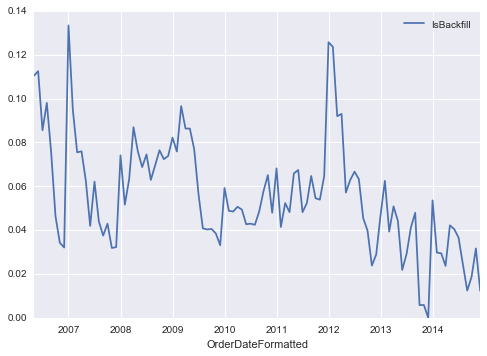

In [107]:
#percentage of company by month who backfilled

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsBackfill')

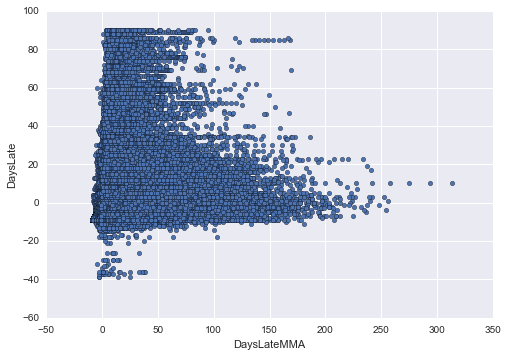

In [186]:
USMTO_NO_SUBMIT_BACKFILL.plot.scatter('DaysLateMMA','DaysLate')

In [204]:
AAID_BY_MONTH['Count of Orders'] = USMTO_WHOLE

,OrderDateFormatted,DaysLate,TotalSale,IsEmailOne,IsEmailTwo,IsCall,IsBackfill
AAID,,,,,,,
123,2007-12-01,522.0,1.846154e+04,1,1,1,1
123,2010-10-01,673.0,1.000000e+05,1,1,1,1
100005,2006-05-01,-5.0,1.314387e+05,0,0,0,0
100005,2006-06-01,1.0,1.539455e+05,1,0,0,0
100005,2006-07-01,-8.0,5.797109e+04,0,0,0,0
100005,2006-08-01,15.0,6.599400e+04,1,1,1,0
100005,2006-10-01,3.0,1.063480e+05,1,0,0,0
100005,2006-11-01,-3.0,1.291431e+05,0,0,0,0
100005,2006-12-01,-7.0,6.636000e+04,0,0,0,0


In [108]:
#APPENDIX AS FOLLOWS: (works in progress)

In [ ]:
#cols to create:

3 MMA company sales
3 MMA lateness
# s&p 500 DONE
machine tool mix
prior month late days
scatter matrix



In [109]:
#attempts to map which AAIDs submitted over what dates

AAIDs = pd.DataFrame.from_csv('AAIDs.csv', index_col = False)

In [110]:
AAIDs = AAIDs.fillna('')

In [111]:
AAIDs

,Unique AAID,Unique Dates,Index
0,123,1-1997,123 1-1997
1,100001,2-1997,100001 2-1997
2,100002,3-1997,100002 3-1997
3,100004,4-1997,100004 4-1997
4,100005,5-1997,100005 5-1997
5,100007,6-1997,100007 6-1997
6,100009,7-1997,100009 7-1997
7,100010,8-1997,100010 8-1997
8,100011,9-1997,100011 9-1997
9,100012,10-1997,100012 10-1997


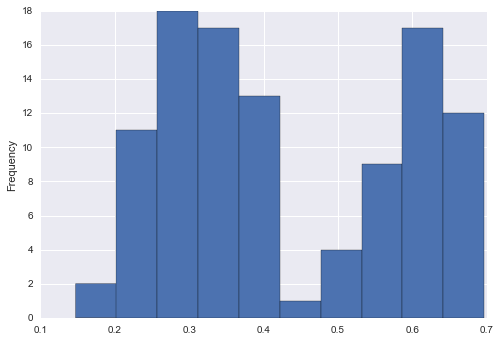

In [112]:
#plots distribution who received a first email, over all time

USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailOne'].mean().plot(kind = 'hist',bins = 10)

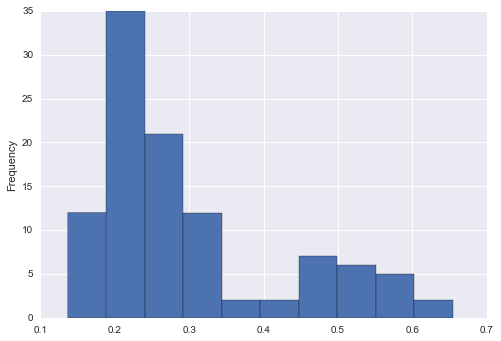

In [113]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailTwo'].mean().plot(kind = 'hist',bins = 10)

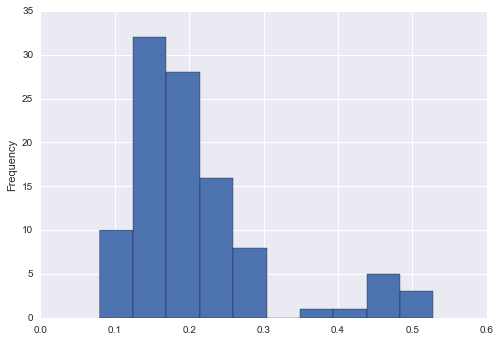

In [114]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsCall'].mean().plot(kind = 'hist',bins = 10)

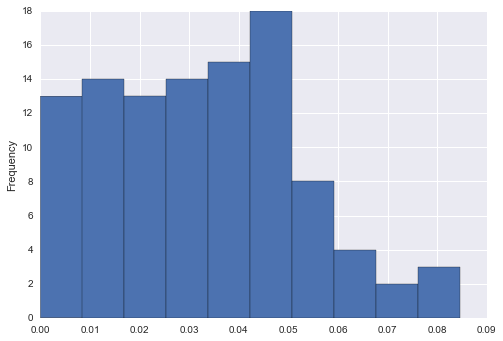

In [115]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsBackfill'].mean().plot(kind = 'hist',bins = 10)

In [120]:
USMTO_WHOLE

,OrderID,AAID,NAICSID,CustomerZipCode,ShippingCountryID,ShippingZipCode,Units,TotalSale,CreatedBy,CreateDate,...,EntryYear,OrderDateFormatted,ChangedDateFormatted,SubmitDateFormatted,OrderDateEOM,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill
0,5f545239-d6cb-4bdb-a031-005965d53dff,100290,223,48162,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48162,1,67405.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:29:17 AM,...,2014,2014-01-01,2014-02-19 08:29:17,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0
1,7ea1df73-7202-4994-8b9b-01701fc0eff5,100290,218,48726,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48726,1,69995.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:22:46 AM,...,2014,2014-01-01,2014-02-19 08:22:46,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0
2,a0cecbb0-0c70-4435-b90c-1a40886b22c7,100290,193,49004,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49004,1,209217.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:07:57 AM,...,2014,2014-01-01,2014-02-19 08:07:57,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0
3,262406fb-462d-4d7e-8717-23104d817c73,100290,253,48212,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48212,1,203526.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:03:20 AM,...,2014,2014-01-01,2014-02-19 08:03:20,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0
4,afbed794-b70a-44df-9bbc-4c1078733462,100290,526,48309,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48309,1,177569.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:24:07 AM,...,2014,2014-01-01,2014-02-19 08:24:07,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0
5,4c53ffc6-b8d7-4431-ac4a-518d0d4caf12,100290,587,49022,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49022,1,27005.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:26:15 AM,...,2014,2014-01-01,2014-02-19 08:26:15,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0
6,9ffbb48a-f62c-4fc7-b296-6804e7348e06,100290,587,49002,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49002,1,32065.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:28:16 AM,...,2014,2014-01-01,2014-02-19 08:28:16,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0
7,b8fc73a4-f3cb-4049-85a3-6cea8c32eb1c,100290,221,49087,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49087,1,93425.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:12:33 AM,...,2014,2014-01-01,2014-02-19 08:12:33,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0
8,d3bea957-ea95-4a05-b284-721e8998655f,100290,205,48661,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48661,1,72578.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:06:45 AM,...,2014,2014-01-01,2014-02-19 08:06:45,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0
9,cd1d5bf8-6f0b-4d1d-b938-7a24d2563ab4,100290,218,48211,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48211,1,74077.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:21:25 AM,...,2014,2014-01-01,2014-02-19 08:21:25,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0
